Name: Ali Gowani <br>
Contact: https://www.linkedin.com/in/aliagowani/<br>
Created: Monday, August 24, 2020 <br>
Updated: Monday, August 24, 2020 <br>


# 0. Description and Overview (Regression and Classification in Pycaret 2.1)

We are going to utilize a low-code Machine Learning Python library, Pycaret (version 2.1), to predict the First Call Resolution (FCR) metric for Customer Service Agents in Call Centers. FCR is an important metric in the call center space as it indicates the percentage of issues that were resolved when the customer called the first time. We want to ensure that customers do not keep calling back to resolve an issue as it costs the company money when the issue is not resolved the first time.

Below is the approach we will take to predict a Customer Service Agent or Contact Agents FCR metric:
<ol>
<li>Conduct Exploratory Data Analysis (EDA) on the real data from a large customer call center.</li>
<li>Execute regerssion models to determine how accurately we can predict the FCR metric for each Agent.</li>
<li>Execute classification models to determine whether predicting an agent's increase or decrease in FCR metric performance is more meaningful.</li>
</ol>

We evaluated three models and showed that the deep learning model is the most accurate, even with the limited features and a small dataset. We will look at accuracy though, it may be argued that F1 Score may be more relevant:
<ol>
<li>Create charts to better understnd our baseline data.</li>
<li>Execute regression and classification models to predict FCR metric.</li>
<li>Dig deeper by using advanced (and very easy) Pycaret functionaility such as, Feature generation, Stacking models and Blending models to improve performance and accuracy.</li>
<li>Use built-in charts in Pycaret to evaluate our findings and make a recommendation.</li>
</ol>

We will leverage a real-case data from a business process outsourcer (BPO) that supports many Fortune 500 companies. *Note: dataset has been sanitized of personal information as it is a real dataset.

Let's get started!

# 1. Load Libraries

In [1]:
# Confirm Pycaret version of 2.1
from pycaret.utils import version
version()

pycaret-nightly-0.44


In [2]:
# Import libraries for data processing.
import numpy as np
import pandas as pd
import warnings
import time
warnings.filterwarnings('ignore')

# Import Tensorflow and Keras Libraries.
# import tensorflow
# from tensorflow.python.keras import backend as K
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LeakyReLU
# from keras.optimizers import Adam
# from keras import metrics

# Import sklearn libraries for data processing.
# import sklearn
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import fbeta_score
# from sklearn.metrics import classification_report
# from sklearn.utils import class_weight

In [3]:
# Install and import Pycaret library for transformation and classification.
# !pip install pycaret
from pycaret.regression import *

In [4]:
# Installing the latest recent version of skopt directly from Github
# !pip install scikit-optimize

# Install and import Scikit Optimize library for Bayesian optimization using Gaussian Processes
# from skopt import gbrt_minimize, gp_minimize
# from skopt.utils import use_named_args
# from skopt.space import Real, Categorical, Integer
# from skopt.plots import plot_convergence
# from skopt.plots import plot_objective
# from skopt import dump, load

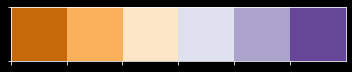

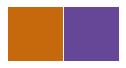

In [5]:
# Import libraries for visualization and set default values.
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette("PuOr"))
pal = sns.color_palette('PuOr', 6)
pal.as_hex()
plt.style.use(['seaborn'])
sns_colors = ["#c6690c", "#664697"]
sns.set_palette(sns_colors)
sns.palplot(sns.color_palette(sns_colors))

# 2. Load Dataset

In [7]:
# Load Dataset.
url = 'https://raw.githubusercontent.com/aliagowani/Pycaret_2.1_Regression_and_Classification_EmployeePerformance/master/input_data.csv?token=AMLWIYQWLCRIXNWKEKONOI27JU37G'
dataset = pd.read_csv(url)

In [8]:
# Check shape of dataset and view first few observations to ensure data loaded correctly.
print("Shape of dataset (observations, features):", dataset.shape)
dataset.head(5).round(2)

Shape of dataset (observations, features): (102, 19)


,Agent_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Site,Function_Field,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before
0,384091,100.00,90.00,90.00,96.15,100.00,96.88,100.00,Kuala Lumpur,Agent,33,163,95.06,94.23,4.87,0,0,85.71,97.14
1,369185,94.00,100.00,96.87,96.87,96.10,95.89,98.33,Kuala Lumpur,Agent,33,306,95.08,94.67,4.83,0,0,100.00,88.64
2,360854,94.44,80.00,92.94,92.94,100.00,93.94,96.30,Kuala Lumpur,Agent,32,138,94.16,94.74,4.82,2,1,80.00,92.31
3,374407,100.00,95.00,96.63,96.63,92.50,95.65,100.00,Kuala Lumpur,Agent,32,148,98.65,95.83,4.84,0,0,94.44,100.00
4,372496,96.88,95.83,94.28,94.28,83.33,95.35,100.00,Kuala Lumpur,Agent,29,142,97.18,98.55,4.86,0,0,100.00,90.91


# 3. Exploratory Data Analysis (EDA)

In [9]:
# Describe the features in the dataset, such as, count, mean, standard deviation, min, max, etc.
dataset.describe().round(2)

# Below is a high-level descprtion of each feature. The data set is comprised of 102 agents and we have 19 features to evaluate. The data is between the time period of June 1, 2020 and July 31, 2020, with the 'Actual Value' as the Actual FCR value of each agent for August 7, 2020. The goal is to create a model that predicts the FCR the agent can have at the end of the week (Friday). 

# 'Agent_ID': unique identifier of the agent.
# 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday': shows the FCR percent for each agent as an aggregate (mean). The higher the percentage the higher the rate at which the customer's issue was resolved in the first call. 
# 'Site': city location of the call center.
# 'Function_Field': this is the role of the employee. In our case, it should all be Agents. 
# 'tenure': tenure of the agent at the company in months. 
# 'Total number of calls': number of all phone calls taken by the agent in the given timeframe.
# 'Assistance': percentage of time the agent needed to provide additional assistance by escalating to supervisor. 
# 'Recommend': percentage of time the agent would be recommended by the customer to resolve an issue. 
# 'CSat': average survey response (on a scale from 1 (least satisfied) to 5 (most satisfied)) that the customer was satisfied with the experience. 
# 'total coaching': number of times the agent received coaching sessions from supervisor to improve FCR metric in the given timeframe. 
# 'total coaching improved': number of times the agent's FCR value increased after a week from the initial coaching. 
# 'Actual Value': the label we are trying to predict. It is the next Friday (August 7, 2020) FCR value for the agent. 
# 'FCR Week before': a strong indicator is how well the agent performed the previous Friday. This is the FCR value for the Friday before the predicted value ('Actual Value'). 


,Agent_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before
count,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
mean,371097.88,95.65,94.10,95.55,95.19,94.91,94.97,96.54,14.24,173.94,95.83,95.62,4.81,1.61,0.88,96.04,95.58
std,10742.44,4.36,10.47,3.56,3.94,5.45,4.68,3.83,6.85,77.23,1.78,2.00,0.09,1.78,1.07,5.70,4.67
min,353039.00,77.78,0.00,80.56,80.00,75.00,80.00,83.33,3.00,52.00,89.66,87.16,4.41,0.00,0.00,75.00,80.00
25%,362108.00,93.75,92.45,93.87,93.28,92.31,92.94,95.00,8.00,116.25,94.71,94.67,4.77,0.00,0.00,94.12,92.92
50%,371781.00,96.15,94.94,95.83,96.01,96.00,95.86,97.33,15.00,158.00,95.81,95.59,4.82,1.00,1.00,100.00,96.49
75%,380697.75,100.00,100.00,97.56,97.57,100.00,98.15,100.00,17.00,226.25,96.99,97.11,4.87,2.00,1.00,100.00,100.00
max,388627.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,33.00,388.00,100.00,100.00,4.98,9.00,4.00,100.00,100.00


In [8]:
# Initiate local directory
#import os
#os.getcwd()
#os.chdir('/Users/aliagowani/-=STORAGE=-/-=Books=-/Deep learning for Time series by Jason Brownlee/TimeSeriesBook-master/chapter_23')

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.available   
# Use light graphs on dark mode OS
plt.style.use(['seaborn'])

# Pandas Profiling
import pandas_profiling
profile = pandas_profiling.ProfileReport(dataset)
profile.to_file("output.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 51.58it/s]


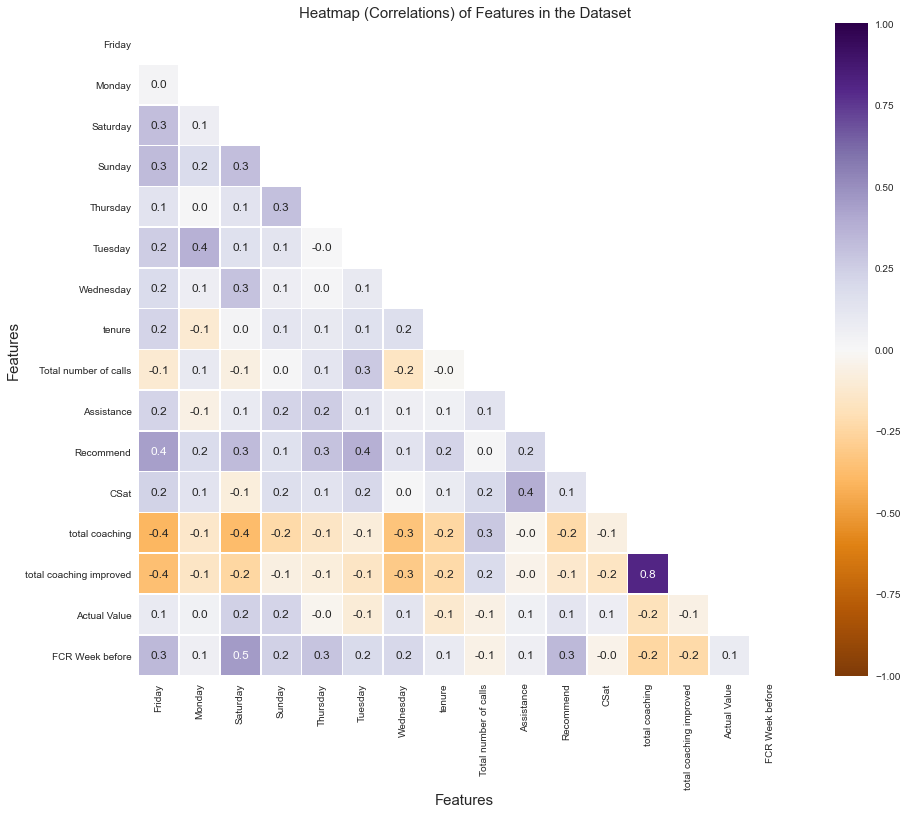

In [10]:
# Create a correlation for the dataset.
dataset_corr = dataset.corr().round(4)

# Drop Agent_ID from correlation dataset.
dataset_corr = dataset_corr.drop(["Agent_ID"], axis=1)
dataset_corr = dataset_corr.drop(["Agent_ID"], axis=0)

# Create a correlation matrix. Only bottom left corner valued. 
mask = np.zeros_like(dataset_corr.round(4))
mask[np.triu_indices_from(mask)] = True

# Generate the corrleation matrix (heatmap) using Seaborn. 
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(16, 12))
    ax = sns.heatmap(dataset_corr.round(2), mask=mask, vmax=1, center = 0, vmin=-1, square=True, cmap='PuOr', linewidths=.5, annot=True, annot_kws={"size": 12}, fmt='.1f')
    plt.title('Heatmap (Correlations) of Features in the Dataset', fontsize=15)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Features', fontsize=15)
plt.show()

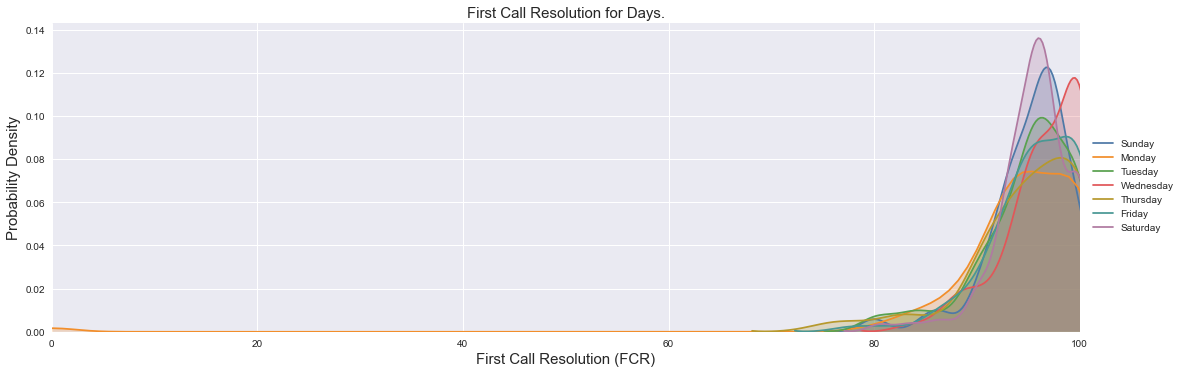

In [11]:
# Visualize the FCR for specific day. 
facet = sns.FacetGrid(dataset, aspect = 3, height=5)
facet.map(sns.kdeplot, 'Sunday', shade = True, color='#4E79A7')
facet.map(sns.kdeplot, 'Monday', shade = True, color='#F28E2B')
facet.map(sns.kdeplot, 'Tuesday', shade = True, color='#59A14F')
facet.map(sns.kdeplot, 'Wednesday', shade = True, color='#E15759')
facet.map(sns.kdeplot, 'Thursday', shade = True, color='#B6992D')
facet.map(sns.kdeplot, 'Friday', shade = True, color='#499894')
facet.map(sns.kdeplot, 'Saturday', shade = True, color='#B07AA1')
facet.set(xlim = (0, dataset['Thursday'].max()))
facet.add_legend()
plt.title('First Call Resolution for Days.', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.xlabel('First Call Resolution (FCR)', fontsize=15)
plt.show()

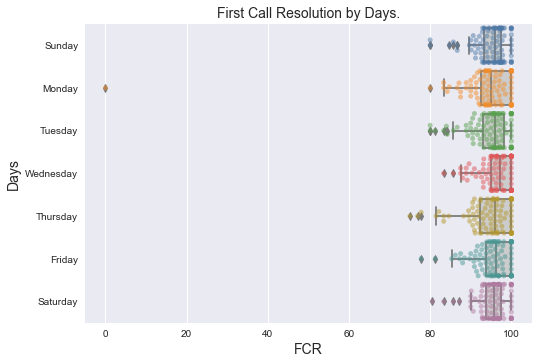

In [50]:
# Visualize the dispersion of FCR values in a given day and identify the outliers. 

# Create a color set that matches the probability density chart. 
my_pal = {'Sunday': '#4E79A7','Monday': '#F28E2B', 'Tuesday': '#59A14F', 'Wednesday': '#E15759', 'Thursday': '#B6992D', 'Friday': '#499894', 'Saturday': '#B07AA1'}

# Generate a boxplot using Seaborn. 
dataset_boxplot = pd.DataFrame(data = dataset, columns = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
sns.boxplot(x="value", y="variable", data=pd.melt(dataset_boxplot), color='#cccccc')
sns.swarmplot(x="value", y="variable", data=pd.melt(dataset_boxplot), palette=my_pal, alpha=0.5)
plt.title('First Call Resolution by Days.', fontsize=14)
plt.ylabel('Days', fontsize=14)
plt.xlabel('FCR', fontsize=14)
plt.show()

In [32]:
ax = sns.boxplot(x="value", y="variable", data=pd.melt(dataset_boxplot))

ax = sns.swarmplot(x="value", y="dvariableay", data=pd.melt(dataset_boxplot), color=".2")

ValueError: Could not interpret input 'dvariableay'

# 4. Transform & Compare Models in PyCaret

In [14]:
dataset.columns

Index(['Agent_ID', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'Site', 'Function_Field', 'tenure',
       'Total number of calls', 'Assistance', 'Recommend', 'CSat',
       'total coaching', 'total coaching improved', 'Actual Value',
       'FCR Week before'],
      dtype='object')

In [9]:
set_config('seed', 786)
seed = get_config('seed')
seed

786

In [23]:
# Transform dataset (transform, bin and create dummy variables) and split. Note that we will 
# create a split of 95% (Train) and 5% (Test). The Test set will actually be our unseen holdout
# set for us to do our final validation. 

set_config('seed', 786)
seed = get_config('seed')

reg_fcr = setup(data=dataset, target='Actual Value', session_id=seed, transformation=True, normalize=True, train_size=0.75, numeric_features=('Sunday', 'Monday', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday', 'Friday', 'Total number of calls', 'CSat', 'total coaching', 'total coaching improved', 'FCR Week before'), remove_outliers=True, outliers_threshold=0.05, remove_multicollinearity=True, multicollinearity_threshold=0.9, feature_selection=True, feature_interaction=True, silent=False, ignore_features=['Agent_ID'], combine_rare_levels=True, polynomial_features=True, trigonometry_features=True, feature_selection_threshold=0.4)


Setup Succesfully Completed.


,Description,Value
0,session_id,786
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(102, 19)"
4,Missing Values,False
5,Numeric Features,16
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [11]:
# Allocateed various splits to appropriate variables
X_train = dl_reg[2]
y_train = dl_reg[4]
X_test = dl_reg[3]
y_test = dl_reg[5]

# Print shape of various splits
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)



X_train (72, 39)
y_train (72,)
X_test (24, 39)
y_test (24,)


In [24]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model.Lasso,True
ridge,Ridge Regression,sklearn.linear_model.Ridge,True
en,Elastic Net,sklearn.linear_model.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model.OMP,True
br,Bayesian Ridge,sklearn.linear_model.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model.ARDRegression,False


In [25]:
# stack trained models dynamically
top5 = compare_models(n_select=5, blacklist=(['ransac']), sort='RMSE', fold=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Light Gradient Boosting Machine,4.1354,29.9853,5.1823,-0.6304,0.0558,0.0452,0.0959
1,Extra Trees Regressor,4.2886,31.3219,5.2839,-0.5264,0.0569,0.0467,0.1432
2,Gradient Boosting Regressor,4.2808,32.3130,5.3514,-0.5802,0.0577,0.0467,0.0773
3,Random Forest,4.4665,33.9718,5.5046,-0.5903,0.0595,0.0488,0.1685
4,CatBoost Regressor,4.4018,34.3669,5.5090,-0.4633,0.0596,0.0486,2.4000
5,Bayesian Ridge,4.4868,33.1356,5.5714,-0.7714,0.0602,0.0490,0.0045
6,Extreme Gradient Boosting,4.5274,36.2177,5.6733,-1.0654,0.0612,0.0488,0.0347
7,Elastic Net,4.6660,35.2919,5.6790,-0.6857,0.0612,0.0511,0.0036
8,AdaBoost Regressor,4.5355,37.7544,5.7164,-0.5901,0.0618,0.0500,0.0782
9,K Neighbors Regressor,4.5608,35.3342,5.7167,-0.7488,0.0616,0.0501,0.0026


In [14]:
pull().sort_values(by='RMSE', ascending=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,AdaBoost Regressor,4.1531,31.8065,4.8381,-0.7351,0.0521,0.0457,0.0863
1,Random Forest,4.3727,32.6420,5.0498,-1.1618,0.0541,0.0476,0.2275
2,CatBoost Regressor,4.4381,33.9284,5.1541,-0.6969,0.0555,0.0489,3.3539
3,Extra Trees Regressor,4.5129,34.0931,5.2309,-1.6376,0.0559,0.0490,0.1450
4,Bayesian Ridge,4.4144,31.6491,5.2410,-1.3114,0.0562,0.0480,0.0059
5,Extreme Gradient Boosting,4.4840,37.5548,5.3336,-1.1335,0.0570,0.0484,0.0427
6,K Neighbors Regressor,4.6444,35.4799,5.4342,-2.0806,0.0584,0.0509,0.0025
7,Gradient Boosting Regressor,4.4896,37.7000,5.4401,-2.3978,0.0583,0.0488,0.0758
8,Elastic Net,4.6418,36.3906,5.4907,-1.3407,0.0589,0.0508,0.0032
9,Lasso Least Angle Regression,4.7969,38.3964,5.6269,-1.3838,0.0603,0.0526,0.0029


In [43]:
# tune multiple models dynamically
tuned_top5 = [tune_model(i, n_iter=121, optimize='RMSE') for i in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.4862,30.5601,5.5281,-0.2267,0.0588,0.0486
1,4.4558,31.5710,5.6188,0.4009,0.0626,0.0505
2,3.5735,27.3130,5.2262,-2.4571,0.0543,0.0360
3,7.0615,67.6318,8.2239,0.0097,0.0911,0.0819
4,3.3292,15.3633,3.9196,-2.6941,0.0401,0.0336
5,6.9775,77.1531,8.7837,-0.0977,0.0984,0.0798
6,3.2192,14.3249,3.7848,-1.2948,0.0384,0.0323
7,4.3660,23.3334,4.8305,-1.4661,0.0496,0.0445
8,3.7562,22.7304,4.7676,-0.3328,0.0497,0.0391
9,4.4014,33.3284,5.7731,0.3660,0.0649,0.0501


In [44]:
blender_specific = blend_models(estimator_list=tuned_top5[0:], fold=20, optimize='RMSE', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.4304,22.0225,4.6928,-0.0051,0.0488,0.0462
1,2.9925,17.6408,4.2001,0.0588,0.0461,0.0338
2,5.8246,49.4747,7.0338,0.1176,0.0785,0.0665
3,3.7069,19.2404,4.3864,0.5851,0.0485,0.0411
4,3.5558,16.4004,4.0497,-0.5781,0.0416,0.0364
5,3.8004,19.7030,4.4388,-13.4146,0.0455,0.0381
6,7.9064,80.3785,8.9654,-0.3260,0.0975,0.0899
7,6.0925,53.0672,7.2847,0.1358,0.0822,0.0714
8,2.3428,6.5014,2.5498,-3.4866,0.0256,0.0235
9,0.9681,1.4481,1.2034,0.6295,0.0124,0.0101


In [45]:
blender_specific

VotingRegressor(estimators=[('Ada Boost Regressor_0',
                             AdaBoostRegressor(base_estimator=None,
                                               learning_rate=0.6399999999999997,
                                               loss='linear', n_estimators=30,
                                               random_state=786)),
                            ('Random Forest Regressor_1',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=100,
                                                   max_features='log2',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_d...
                                            

In [46]:
pred_tunded_dt = predict_model(blender_specific)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,3.4558,14.7663,3.8427,-0.6383,0.0393,0.0353


In [47]:
pred_tunded_dt.to_csv('pred_tuned_dt.csv')

In [48]:
finalize_tuned_dt = finalize_model(blender_specific)
finalize_tuned_dt

VotingRegressor(estimators=[('Ada Boost Regressor_0',
                             AdaBoostRegressor(base_estimator=None,
                                               learning_rate=0.6399999999999997,
                                               loss='linear', n_estimators=30,
                                               random_state=786)),
                            ('Random Forest Regressor_1',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=100,
                                                   max_features='log2',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_d...
                                            

In [49]:
pred_tunded_dt4 = predict_model(finalize_tuned_dt, data=dataset)
pred_tunded_dt4.to_csv('pred_tuned_dt4.csv')
pred_tunded_dt4.describe()

,ASAP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before,Label
count,1.020000e+02,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,2.687997e+07,95.650593,94.096218,95.552565,95.186928,94.907817,94.968364,96.544911,14.235294,173.941176,95.832315,95.622119,4.807622,1.607843,0.882353,96.036176,95.578725,96.108479
std,1.254397e+06,4.355132,10.465289,3.558242,3.941495,5.453729,4.675461,3.829237,6.846516,77.234608,1.784522,1.997818,0.089011,1.775281,1.074402,5.700526,4.674600,2.771863
min,2.670259e+07,77.777778,0.000000,80.555556,80.000000,75.000000,80.000000,83.333333,3.000000,52.000000,89.655172,87.162162,4.413793,0.000000,0.000000,75.000000,80.000000,85.196200
25%,2.670324e+07,93.750000,92.445055,93.873767,93.284134,92.307692,92.938312,95.000000,8.000000,116.250000,94.711729,94.666667,4.767000,0.000000,0.000000,94.120000,92.920000,95.416350
50%,2.670353e+07,96.153846,94.935897,95.833414,96.013439,96.000000,95.861872,97.329060,15.000000,158.000000,95.806136,95.589688,4.819492,1.000000,1.000000,100.000000,96.490000,96.911550
75%,2.670380e+07,100.000000,100.000000,97.556895,97.568007,100.000000,98.146168,100.000000,17.000000,226.250000,96.988326,97.113066,4.865194,2.000000,1.000000,100.000000,100.000000,97.805600
max,3.570632e+07,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,33.000000,388.000000,100.000000,100.000000,4.984127,9.000000,4.000000,100.000000,100.000000,98.958200


In [50]:
pred_tunded_dt4

,ASAP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Site,Function_Field,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before,Label
0,26702594,100.000000,90.000000,90.000000,96.145833,100.000000,96.875000,100.000000,Santa Rosa,Agent,33,163,95.061728,94.230769,4.865031,0,0,85.71,97.14,88.8288
1,26702611,94.000000,100.000000,96.865528,96.865528,96.103896,95.890411,98.333333,Santa Rosa,Agent,33,306,95.081967,94.666667,4.830065,0,0,100.00,88.64,98.0716
2,26702625,94.444444,80.000000,92.936027,92.936027,100.000000,93.939394,96.296296,Santa Rosa,Agent,32,138,94.160584,94.736842,4.818841,2,1,80.00,92.31,87.2875
3,26702629,100.000000,95.000000,96.630435,96.630435,92.500000,95.652174,100.000000,Santa Rosa,Agent,32,148,98.648649,95.833333,4.844595,0,0,94.44,100.00,96.6578
4,26702675,96.875000,95.833333,94.278101,94.278101,83.333333,95.348837,100.000000,Santa Rosa,Agent,29,142,97.183099,98.550725,4.859155,0,0,100.00,90.91,97.3947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,26703888,98.148148,96.153846,97.516525,97.516525,97.826087,95.454545,100.000000,Santa Rosa,Agent,6,240,95.815900,93.913043,4.883333,1,1,100.00,95.24,97.2604
98,26703895,92.452830,93.253091,95.454545,97.560976,91.666667,93.253091,89.130435,Santa Rosa,Agent,6,244,93.004115,92.016807,4.852459,4,3,100.00,93.10,97.9391
99,26703899,95.652174,97.058824,94.317739,98.305085,89.473684,91.666667,93.750000,Santa Rosa,Agent,6,250,95.951417,94.628099,4.792000,0,0,90.00,89.19,94.0490
100,35706305,87.229437,86.666667,87.229437,92.857143,90.909091,80.000000,85.714286,Pueblo,Agent,6,52,98.000000,91.836735,4.961538,4,3,93.33,85.71,92.9865


# 3.1 Predict on new data with finalized Blender Specific model

In [69]:
# Load Dataset for FCR August 7.
url = 'https://raw.githubusercontent.com/aliagowani/Deep_Learning_Contact_Center_Regression/master/input%20data%20v2%20-%20FCR%20Aug7.csv?token=AMLWIYSVBDW65CQHLBQGUHK7IVEM2'
dataset2 = pd.read_csv(url)

In [70]:
# Check shape of dataset and view first 10 observations.
print(dataset2.shape)
dataset2.head(5).round(2)

(102, 19)


,ASAP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Site,Function_Field,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before
0,26702594,100.00,90.00,90.00,94.53,92.31,94.87,100.00,Santa Rosa,Agent,34,190,95.24,95.08,4.85,0,0,100.00,85.71
1,26702611,95.00,100.00,97.30,97.30,96.55,96.51,98.44,Santa Rosa,Agent,34,349,95.69,94.63,4.85,0,0,100.00,100.00
2,26702625,94.44,80.00,92.94,92.94,100.00,93.94,96.30,Santa Rosa,Agent,32,143,93.62,94.89,4.80,2,1,85.71,80.00
3,26702629,100.00,91.30,96.26,96.26,93.02,96.97,100.00,Santa Rosa,Agent,32,172,98.26,96.34,4.86,0,0,96.67,94.44
4,26702675,96.88,96.88,94.58,94.58,83.33,95.83,100.00,Santa Rosa,Agent,29,155,97.42,98.67,4.87,0,0,100.00,100.00


In [71]:
# Describe the features in the dataset, such as, count, mean, standard deviation, min, max, etc.
dataset2.describe().round(2)

,ASAP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before
count,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
mean,26879951.87,95.88,93.94,94.87,95.35,95.04,95.28,96.45,14.67,188.10,95.75,95.60,4.80,1.60,0.85,95.16,95.46
std,1254399.90,4.38,10.86,4.12,3.72,4.85,4.12,4.03,6.97,89.50,1.61,2.02,0.09,1.87,1.16,5.92,6.25
min,26702594.00,77.78,0.00,77.50,80.00,77.78,80.00,83.33,4.00,52.00,88.54,86.67,4.43,0.00,0.00,66.67,71.43
25%,26703233.75,93.77,92.86,93.42,93.60,92.66,93.22,94.16,8.25,123.25,94.84,94.60,4.76,0.00,0.00,93.22,92.86
50%,26703513.50,96.16,95.08,95.55,95.93,95.77,96.04,97.31,15.00,167.00,95.74,95.60,4.81,1.00,0.00,96.43,98.78
75%,26703780.25,100.00,100.00,97.28,97.72,100.00,98.09,100.00,17.00,255.25,96.73,97.02,4.86,2.00,1.00,100.00,100.00
max,35706317.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,34.00,440.00,100.00,100.00,4.94,9.00,6.00,100.00,100.00


In [72]:
pred_tunded_dt4_aug7 = predict_model(finalize_tuned_dt, data=dataset2)
pred_tunded_dt4_aug7.to_csv('pred_tuned_dt4_aug7.csv')
pred_tunded_dt4_aug7.round(2)

,ASAP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Site,Function_Field,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before,Label
0,26702594,100.00,90.00,90.00,94.53,92.31,94.87,100.00,Santa Rosa,Agent,34,190,95.24,95.08,4.85,0,0,100.00,85.71,94.95
1,26702611,95.00,100.00,97.30,97.30,96.55,96.51,98.44,Santa Rosa,Agent,34,349,95.69,94.63,4.85,0,0,100.00,100.00,98.21
2,26702625,94.44,80.00,92.94,92.94,100.00,93.94,96.30,Santa Rosa,Agent,32,143,93.62,94.89,4.80,2,1,85.71,80.00,90.57
3,26702629,100.00,91.30,96.26,96.26,93.02,96.97,100.00,Santa Rosa,Agent,32,172,98.26,96.34,4.86,0,0,96.67,94.44,95.30
4,26702675,96.88,96.88,94.58,94.58,83.33,95.83,100.00,Santa Rosa,Agent,29,155,97.42,98.67,4.87,0,0,100.00,100.00,97.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,26703877,100.00,100.00,100.00,100.00,100.00,87.50,100.00,Santa Rosa,Agent,6,162,95.68,94.90,4.85,1,1,97.62,100.00,97.92
98,26703888,96.88,96.55,97.58,97.58,98.41,96.08,100.00,Santa Rosa,Agent,6,291,96.21,93.95,4.88,1,1,100.00,100.00,98.51
99,26703895,93.65,93.02,94.23,95.56,90.77,93.02,90.91,Santa Rosa,Agent,6,280,93.19,92.52,4.87,4,3,66.67,100.00,98.63
100,35706305,89.57,89.47,89.57,93.75,84.62,90.00,90.00,Pueblo,Agent,6,68,96.92,90.32,4.81,4,3,87.50,93.33,99.04


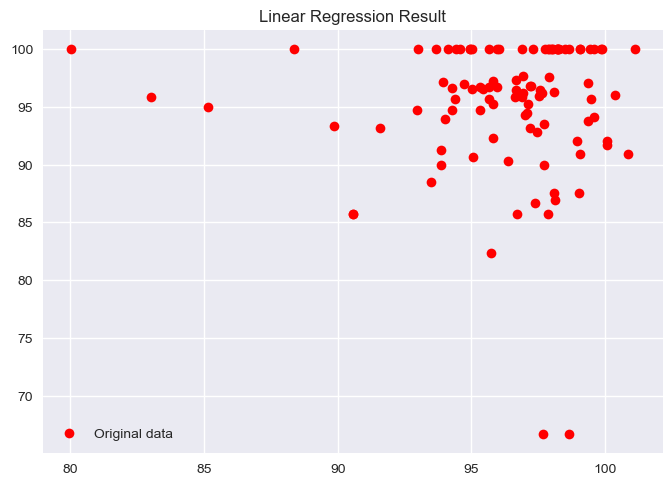

In [73]:
plt.plot(pred_tunded_dt4_aug7['Label'], pred_tunded_dt4_aug7['Actual Value'], 'ro', label ='Original data') 
plt.title('Linear Regression Result') 
plt.legend() 
plt.show() 

In [76]:
pip uninstall pandas-profiling

Found existing installation: pandas-profiling 2.8.0
Uninstalling pandas-profiling-2.8.0:
  Would remove:
    /Users/aliagowani/opt/anaconda3/bin/pandas_profiling
    /Users/aliagowani/opt/anaconda3/lib/python3.7/site-packages/pandas_profiling-2.8.0.dist-info/*
    /Users/aliagowani/opt/anaconda3/lib/python3.7/site-packages/pandas_profiling/*
Proceed (y/n)?^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [75]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.available   
# Use light graphs on dark mode OS
plt.style.use(['seaborn'])

# Pandas Profiling
import pandas_profiling
profile = pandas_profiling.ProfileReport(pred_tunded_dt4_aug7)
profile.to_file("output.html")

OSError: '/Users/aliagowani/opt/anaconda3/lib/python3.7/site-packages/pandas_profiling/pandas_profiling.mplstyle' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

# 4. Create Preliminary Deep Learning Model (Baseline)

In [28]:
# Create a simple (blackbox) model for comparison to the Gaussian Process model.
model = Sequential()
model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', name = 'input_layer', input_dim=X_train.shape[1]))
model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', name = 'hidden_layer'))
model.add(Dense(units = 1, activation='linear', name="output_layer"))
optimizer = tensorflow.keras.optimizers.RMSprop(0.001)
model.compile(optimizer = optimizer, loss='mse', metrics=['mae', 'mse', metrics.RootMeanSquaredError()])
model.summary()

# Define earlyStopping to limit epochs
earlyStopping = [keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose=0), keras.callbacks.ModelCheckpoint(filepath = 'bestModel.hdf5', monitor = 'val_loss', save_best_only = True)]

# Fit the blackbox model.
blackbox = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=.25, callbacks=earlyStopping, verbose=2)

# Evaluate the blackbox model and print accuracy
accuracy = model.evaluate(X_test, y_test)
print("\n", "Accuracy Simple Neural Network Model:", accuracy, "\n")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 64)                2624      
_________________________________________________________________
hidden_layer (Dense)         (None, 64)                4160      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 6,849
Trainable params: 6,849
Non-trainable params: 0
_________________________________________________________________
Train on 54 samples, validate on 18 samples
Epoch 1/5
 - 1s - loss: 9182.4756 - mae: 95.6139 - mse: 9182.4756 - root_mean_squared_error: 95.8252 - val_loss: 9200.9082 - val_mae: 95.7534 - val_mse: 9200.9082 - val_root_mean_squared_error: 95.9214
Epoch 2/5
 - 0s - loss: 9163.5693 - mae: 95.5147 - mse: 9163.5693 - root_mean_squared_error: 95.7265 - val_loss: 9186.6797 - val_mae: 95

# 6. Define Bayesian Optimization Gaussian Process

In [29]:
# Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
K.clear_session()
tensorflow.compat.v1.get_default_graph()
tensorflow.compat.v1.reset_default_graph()
tensorflow.keras.backend.clear_session()

# Declare and instantiate variables
COUNT = 0
time_list = []

# Enable class weights if you have a unbalanced dataset
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
#class_weights = dict(enumerate(class_weights))

# Create search parameters using "dim_" short for dimension. The search will take place across nearly every parameter in the keras model. This will include: Number of Layers, Number of Nodes per layer, Learning Rate & Weight Decay for the Adam Optimizer, activation functions, batch size and Dropout rate.
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_input_nodes = Integer(low=1, high=512, name='num_input_nodes')
dim_num_dense_nodes = Integer(low=1, high=512, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'tanh', 'selu', 'elu', 'linear', 'softplus', 'softmax', 'softsign', 'sigmoid'], name='activation')
dim_batch_size = Integer(low=1, high=256, name='batch_size')
#dim_adam_decay = Real(low=1e-6,high=1e-2, prior='uniform', name="adam_decay")
dim_dropout_rate = Real(low=0.0, high=0.5, prior='uniform', name="dropout_rate")

# Establish the variables in the deminsions variable.
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              #dim_adam_decay,
              dim_dropout_rate
             ]

In [30]:
# Declare the initial value for each variable.
default_parameters = [1e-3, 1, 512, 13, 'relu', 64, .1]

In [31]:
# Define the create_model to go through various combinations of parameters.
def create_dl_model(learning_rate, num_dense_layers, num_input_nodes, num_dense_nodes, activation, dropout_rate):
    # Start the model creation process. 
    model = Sequential()
    model.add(Dense(num_input_nodes,
                    input_dim=X_train.shape[1],
                    activation=activation
                   ))
    model.add(Dropout(dropout_rate))
    
    # Create a loop making a new dense layer for the amount passed to this model.
    # Name the layers to help avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                 name=name
                 ))
        model.add(Dropout(dropout_rate))
        
    # Add our classification layer.
    model.add(Dense(1, activation='linear'))
    
    # Setup the optimizer and compile.
    optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse', metrics.RootMeanSquaredError()])

    return model

In [32]:
# Define the arguments for the dimensions including earlyStopping for epochs.
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_input_nodes, num_dense_nodes, activation, batch_size, dropout_rate):

    # Create a model template.            
    model = create_dl_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_input_nodes=num_input_nodes,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         #adam_decay=adam_decay,
                         dropout_rate=dropout_rate
                        )
    
    # Define earlyStopping to limit epochs.
    earlyStopping = [keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0), keras.callbacks.ModelCheckpoint(filepath='bestModel.hdf5', monitor='val_loss', save_best_only=True)]

    # Initiate start time to track duration of each model.
    start = time.time()

    # Set random seet for tensorflow model.
    tensorflow.random.set_seed(786)

    # Establish a blackbox model to fit. Note: verbose is set to 0 to limit memory consumption when executing search.
    blackbox = model.fit(x=X_train,
                        y=y_train,
                        epochs=100,
                        batch_size=batch_size,
                        validation_split=0.25,
                        callbacks=earlyStopping,
                        #class_weight=class_weights,
                        shuffle=False,
                        verbose=0
                        )
    # Returns the validation accuracy for the last epoch.
    accuracy = blackbox.history['val_root_mean_squared_error'][-1]

    # Capture end time for the duration of each model.
    end = time.time()

    # Define counter using COUNT variable.
    def increment():
        global COUNT
        COUNT = COUNT+1
    increment()

    # Define time_list to keep track of duration for each model.
    def time_list():
        global time_list
        time_list.append(end-start)
    time_list()

    # Print the n_call, duration and accuracy for each model.
    print("n_call:", COUNT)
    print("Time (seconds):", round((end - start),2))
    print("Error (RMSE): {0:.2}".format(accuracy))
    print("")

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
    K.clear_session()
    tensorflow.compat.v1.get_default_graph()
    tensorflow.compat.v1.reset_default_graph()
    tensorflow.keras.backend.clear_session()

    return accuracy

# 7. Execute Bayesian Optimization Search

In [33]:
# Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
K.clear_session()
tensorflow.compat.v1.get_default_graph()
tensorflow.compat.v1.reset_default_graph()
tensorflow.keras.backend.clear_session()

In [34]:
# Execute the Bayesian optimization using Gaussian Processes.
gp_result = gp_minimize(func=fitness,
                            dimensions = dimensions,
                            n_calls = 50,
                            #noise = 'guassian',
                            #n_jobs = -1,
                            #kappa = 2.96,
                            random_state = 786,
                            #acq_func = 'EI', # Expected Improvement.
                            x0 = default_parameters)

# Dump model into a pickle file for future reference. 
# dump(gp_result, 'gp_result.pkl')

n_call: 1
Time (seconds): 3.73
Error (RMSE): 6e+01

n_call: 2
Time (seconds): 4.12
Error (RMSE): 9.3e+01

n_call: 3
Time (seconds): 7.53
Error (RMSE): 9.6e+01

n_call: 4
Time (seconds): 3.14
Error (RMSE): 3.2e+01

n_call: 5
Time (seconds): 4.1
Error (RMSE): 9.5e+01

n_call: 6
Time (seconds): 1.61
Error (RMSE): 2.4e+02

n_call: 7
Time (seconds): 4.04
Error (RMSE): 4.1e+01

n_call: 8
Time (seconds): 3.32
Error (RMSE): 8.9e+01

n_call: 9
Time (seconds): 2.75
Error (RMSE): 8.9e+01

n_call: 10
Time (seconds): 6.06
Error (RMSE): 9.5e+01

n_call: 11
Time (seconds): 2.08
Error (RMSE): 2e+02

n_call: 12
Time (seconds): 5.38
Error (RMSE): 5.9

n_call: 13
Time (seconds): 3.68
Error (RMSE): 6.7e+01

n_call: 14
Time (seconds): 4.83
Error (RMSE): 9.6e+01

n_call: 15
Time (seconds): 9.24
Error (RMSE): 9.3e+01

n_call: 16
Time (seconds): 2.65
Error (RMSE): 9e+01

n_call: 17
Time (seconds): 5.79
Error (RMSE): 5.3e+01

n_call: 18
Time (seconds): 12.63
Error (RMSE): 4.3e+01

n_call: 19
Time (seconds): 18

In [35]:
# Print the accuary of the best model.
print("Best Model (RMSE): " + str(round(gp_result.fun * 1, 2)) + ".")

Best Model (RMSE): 5.68.


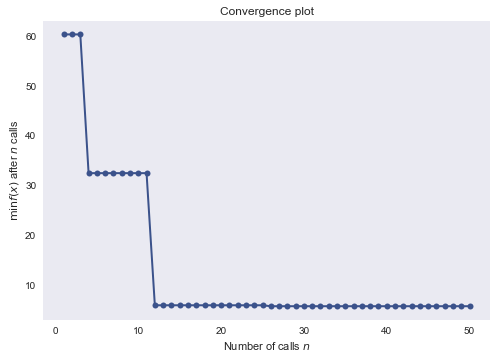

In [36]:
# Plot SKOPT convergence traces.
_ = plot_convergence(gp_result)

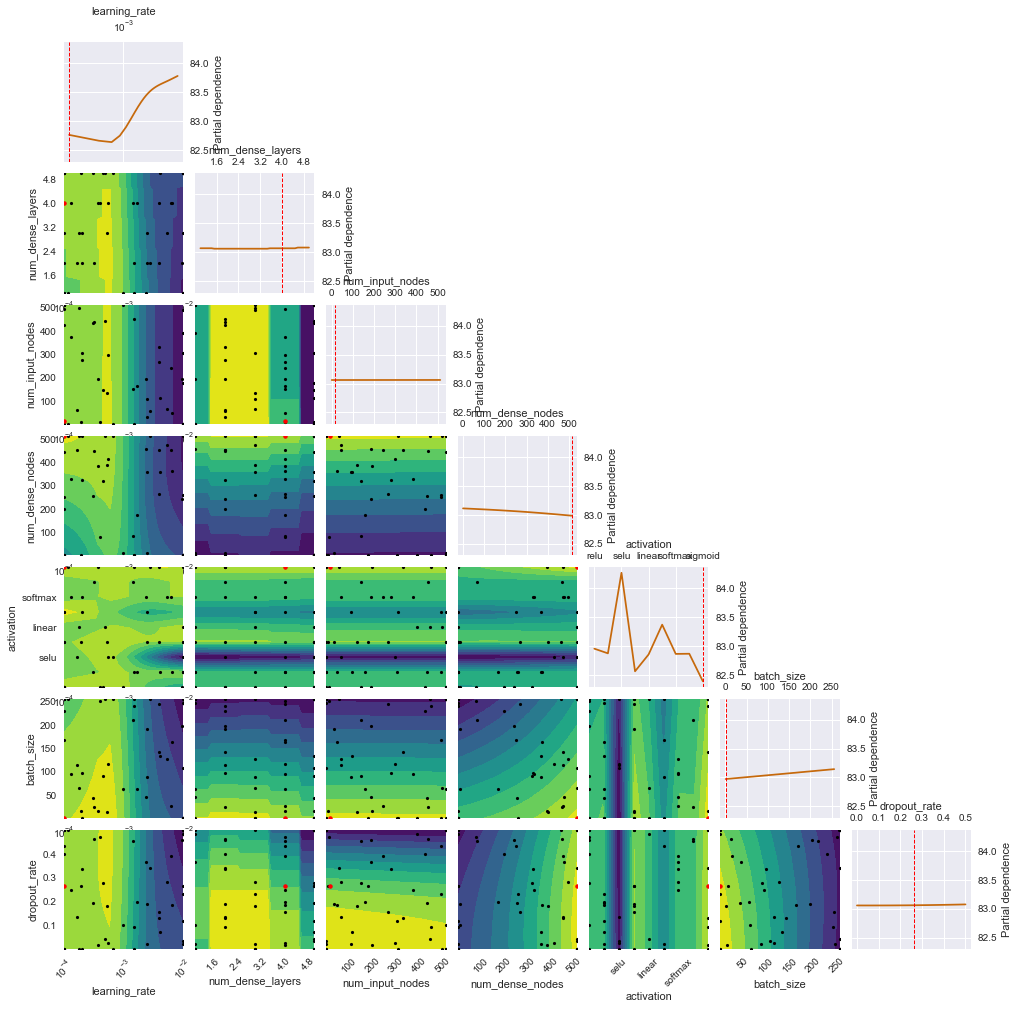

In [37]:
# Show pairwise dependence plot of the objective function.
_ = plot_objective(gp_result)

In [38]:
# Create a dataframe of the results.
df_gp_result = pd.concat([pd.DataFrame(gp_result.x_iters, 
                    columns = ["learning_rate", "hidden layers","input layer nodes","hidden layer nodes", "activation function", "batch size", "dropout rate"]), (pd.Series(gp_result.func_vals*1, name="rmse").round(3))], axis=1)

# Add duration of each model into the dataframe.
time_list = pd.DataFrame(time_list)

# Round the duration of each model.
df_gp_result['time (seconds)'] = round(time_list,2)

# Sort the models by accuracy (descending order).
df_gp_result_saved = df_gp_result.sort_values(by='rmse', ascending=True)

In [39]:
# Display the top 5 most accurate models
df_gp_result_saved.head(10)

,learning_rate,hidden layers,input layer nodes,hidden layer nodes,activation function,batch size,dropout rate,rmse,time (seconds)
25,0.000100,4,16,512,sigmoid,1,0.263667,5.678,36.58
11,0.003912,2,329,453,sigmoid,142,0.129502,5.866,5.38
49,0.010000,5,305,1,tanh,1,0.117338,8.336,21.50
48,0.000205,3,307,512,softplus,1,0.000000,8.970,2.29
30,0.002752,2,56,512,sigmoid,256,0.338951,10.362,4.34
45,0.000101,4,492,253,softplus,168,0.433560,11.735,6.73
47,0.000100,5,1,512,relu,1,0.500000,11.913,21.64
46,0.010000,5,179,1,elu,1,0.265145,13.816,24.11
27,0.000681,5,1,512,selu,256,0.000000,22.391,2.80
42,0.000100,3,512,512,relu,256,0.500000,25.746,5.40


In [40]:
# Save and read data into a CSV file for future reference.
# df_gp_result_saved.to_csv('df_gp_result_saved.csv', index=True, index_label='index', header=True)

# Load the df_gp_result_saved.csv if returning.
# df_gp_result_saved = pd.read_csv('df_gp_result_saved.csv', index_col=0, header=0)

# 8. Create the selected Deep Learning model & validate

In [41]:
# Identify the best model (index number) that meets our criteria and input the index number from df_gp_result_saved.
gp_model_parameters = gp_result.x_iters[df_gp_result_saved.index[0]]
gp_model_parameters

[0.0001, 4, 16, 512, 'sigmoid', 1, 0.2636667078492709]

In [42]:
# Clear the Keras session to ensure it does not add the model to the same tensorflow graphy.
K.clear_session()
tensorflow.compat.v1.get_default_graph()
tensorflow.compat.v1.reset_default_graph()
tensorflow.keras.backend.clear_session()

# Create a model based on the best model we have selected.
gp_model = create_dl_model(gp_model_parameters[0], gp_model_parameters[1], 
                        gp_model_parameters[2], gp_model_parameters[3],
                        gp_model_parameters[4], gp_model_parameters[6])

# Display our final model. 
gp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                656       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 512)               8704      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
layer_dense_2 (Dense)        (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
layer_dense_3 (Dense)        (None, 512)              

In [43]:
# Select optimizer then compile and fit the selected model.
#adam = Adam(lr=gp_model_parameters[0], decay=gp_model_parameters[6])
gp_model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse', metrics.RootMeanSquaredError()])

# Create earlyStopping call back.
earlyStopping = [keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0), 
                 keras.callbacks.ModelCheckpoint(filepath='bestModel.hdf5', monitor='val_loss', save_best_only=True)]

# Fit the model using the best selected parameters.
history = gp_model.fit(X_train, y_train, 
                       validation_data=(X_test, y_test), 
                       epochs=150, 
                       callbacks=earlyStopping, 
                       batch_size=gp_model_parameters[5], 
                       verbose=2)

Train on 72 samples, validate on 24 samples
Epoch 1/150
 - 2s - loss: 5246.8588 - mae: 71.8821 - mse: 5246.8589 - root_mean_squared_error: 72.4352 - val_loss: 4111.3463 - val_mae: 64.0495 - val_mse: 4111.3472 - val_root_mean_squared_error: 64.1198
Epoch 2/150
 - 1s - loss: 2928.4312 - mae: 53.5304 - mse: 2928.4307 - root_mean_squared_error: 54.1150 - val_loss: 2177.6130 - val_mae: 46.5682 - val_mse: 2177.6130 - val_root_mean_squared_error: 46.6649
Epoch 3/150
 - 1s - loss: 1332.0291 - mae: 35.6128 - mse: 1332.0291 - root_mean_squared_error: 36.4970 - val_loss: 794.3167 - val_mae: 28.0233 - val_mse: 794.3167 - val_root_mean_squared_error: 28.1836
Epoch 4/150
 - 1s - loss: 341.9953 - mae: 16.6621 - mse: 341.9952 - root_mean_squared_error: 18.4931 - val_loss: 91.4872 - val_mae: 9.0815 - val_mse: 91.4872 - val_root_mean_squared_error: 9.5649
Epoch 5/150
 - 1s - loss: 76.8526 - mae: 7.1121 - mse: 76.8526 - root_mean_squared_error: 8.7666 - val_loss: 15.5114 - val_mae: 3.5144 - val_mse: 15.5

In [44]:
# Evaluate the selected model.
train_loss, train_mae, train_mse, train_rmse = gp_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae, test_mse, test_rmse = gp_model.evaluate(X_test, y_test, verbose=0)

print("\n", 'Train (Loss): %.3f, Train (MAE): %.3f, Train (MSE): %.3f, Train (RMSE): %.3f' % (train_loss, train_mae, train_mse, train_rmse), "\n")
print("\n", 'Test (Loss): %.3f, Test (MAE): %.3f, Test (MSE): %.3f, Test (RMSE): %.3f' % (test_loss, test_mae, test_mse, test_rmse), "\n")


 Train (Loss): 38.840, Train (MAE): 4.998, Train (MSE): 38.840, Train (RMSE): 6.232 


 Test (Loss): 16.495, Test (MAE): 3.609, Test (MSE): 16.495, Test (RMSE): 4.061 



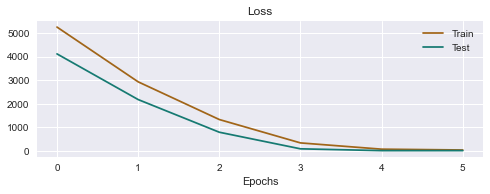

In [45]:
# Plot Loss during training on selected model.
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train', color='#a16518')
plt.plot(history.history['val_loss'], label='Test', color='#167a72')
plt.xlabel('Epochs')
plt.legend()
plt.show()

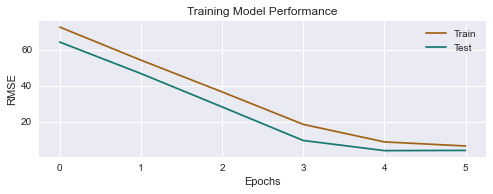

In [46]:
# Plot Accuracy during training on selected model.
plt.subplot(212)
plt.title('Training Model Performance')
plt.plot(history.history['root_mean_squared_error'], label='Train', color='#a16518')
plt.plot(history.history['val_root_mean_squared_error'], label='Test', color='#167a72')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [47]:
# Create classes to compare
y_pred = gp_model.predict(X_test)
y_pred

array([[94.982574],
       [94.98256 ],
       [94.982574],
       [94.982574],
       [94.982574],
       [94.982574],
       [94.982574],
       [94.982574],
       [94.982574],
       [94.982574],
       [94.982574],
       [94.982574],
       [94.98257 ],
       [94.98256 ],
       [94.982574],
       [94.98256 ],
       [94.982574],
       [94.982574],
       [94.982574],
       [94.98256 ],
       [94.982574],
       [94.98256 ],
       [94.98256 ],
       [94.982574]], dtype=float32)

In [48]:
y_test

8      94.12
14     92.86
13    100.00
36    100.00
37    100.00
16    100.00
26    100.00
6      93.33
87    100.00
43     96.30
58     94.12
38    100.00
95    100.00
90    100.00
39     95.00
60    100.00
67     95.83
7     100.00
15     96.30
88     97.37
32    100.00
94    100.00
73    100.00
28     90.00
Name: Actual Value, dtype: float64

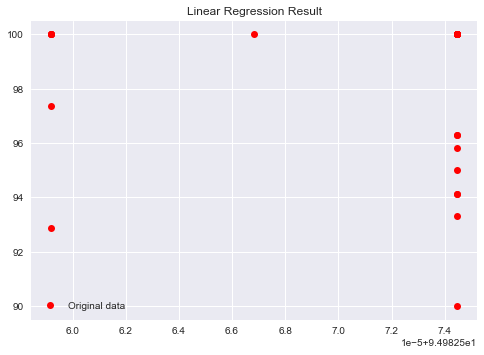

In [49]:
plt.plot(y_pred, y_test, 'ro', label ='Original data') 
#plt.plot(y_pred, y_pred, label ='Fitted line') 
plt.title('Linear Regression Result') 
plt.legend() 
plt.show() 

[Text(0, 0.5, 'Still Customer'), Text(0, 1.5, 'Not Customer')]

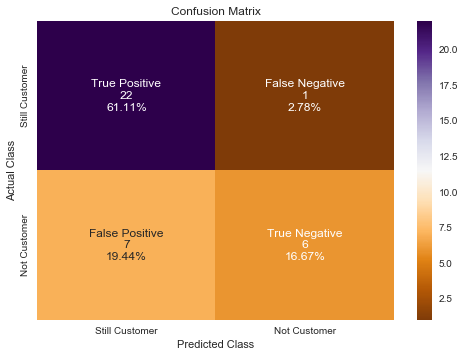

In [41]:
# Create Confusion Matrix for Visualization

# Create classes to compare
y_pred_classes = gp_model.predict_classes(X_test)
y_pred_probs = gp_model.predict(X_test)

# Create a confusion matrix for us to visualize
cf_matrix = confusion_matrix(y_test, y_pred_classes, labels=[1, 0])

# Modify the names and create counts and percentages 
group_names = ['True Positive', 'False Negative', 'False Positive', 'True Negative']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Visualize the heatmap (confusion matrix)
ax = plt.subplot()
plt.rcParams["axes.labelsize"] = 12
plt.rcParams.update({'font.size': 12})
sns.heatmap(cf_matrix, annot=labels, fmt='', ax=ax, annot_kws={'fontsize':12}, cmap='PuOr')

# labels, title and ticks
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Still Customer', 'Not Customer'])
ax.yaxis.set_ticklabels(['Still Customer', 'Not Customer'], va='center')

# 9. Sources and References

Scikit Learn: Learn: Machine learning in Python - scikit-learn 0.16.1 documentation. (n.d.). Retrieved June 11, 2020, from https://scikit-learn.org/

Pycaret. (2020, May 11). Retrieved June 11, 2020, from https://pycaret.org/

TensorFlow. (n.d.). Retrieved June 12, 2020, from https://www.tensorflow.org/

Team, K. (n.d.). Simple. Flexible. Powerful. Retrieved June 12, 2020, from https://keras.io/

Scikit Learn Optimize. (n.d.). Retrieved June 12, 2020, from https://scikit-optimize.github.io/stable/index.html